In [ ]:
"""
chemberta_lora_adalora.ipynb

This script fine-tunes the ChemBERTa model on the ClinTox dataset using parameter-efficient techniques:
- LoRA (Low-Rank Adaptation): Adds trainable low-rank adapters to attention layers, allowing efficient fine-tuning with a small parameter budget.
- AdaLoRA (Adaptive LoRA): Dynamically reallocates the parameter budget during training by mimicking SVD decomposition, enabling even more efficient adaptation.

Key Features:
- Loads and preprocesses the ClinTox dataset using DeepChem and tokenizes SMILES strings.
- Configures and injects LoRA or AdaLoRA adapters into ChemBERTa using Hugging Face PEFT.
- Implements hyperparameter tuning for the learning rate
- Trains only the adapter parameters, keeping the base model frozen.
- Evaluates model performance on validation and test splits.
- Logs metrics (loss, accuracy, parameter counts) for comparison.

You can adjust hyperparameters (rank, alpha, dropout, learning rate, etc.)
"""

In [1]:
%%capture
!pip install deepchem transformers peft

In [2]:
import warnings
import logging

warnings.filterwarnings("ignore", category=DeprecationWarning)
logging.getLogger("deepchem").setLevel(logging.ERROR)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import deepchem as dc
from peft import get_peft_model, LoraConfig, TaskType, AdaLoraConfig
import time
from sklearn.metrics import accuracy_score
from rdkit import Chem
import pandas as pd
import matplotlib.pyplot as plt
import random

random.seed(10)

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [4]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


True

In [5]:
# Define paths and parameters
MODEL_NAME = "seyonec/ChemBERTa-zinc-base-v1"
MAX_LENGTH = 128
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 2e-5

# LoRA Configuration
LORA_R = 8  # Rank of LoRA
LORA_ALPHA = 16
LORA_DROPOUT = 0.1

In [6]:
class ClinToxDataset(Dataset):
    def __init__(self, data_path, tokenizer, split='train', max_length=128):
        """
        Custom PyTorch Dataset for the ClinTox dataset.
        """
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.split = split

        # Load ClinTox dataset from DeepChem
        tasks, datasets, transformers = dc.molnet.load_clintox()
        train_dataset, valid_dataset, test_dataset = datasets

        # Convert to SMILES and labels
        self.smiles_train, self.labels_train = self.remove_invalid_smiles(train_dataset.ids, train_dataset.y)
        self.smiles_valid, self.labels_valid = self.remove_invalid_smiles(valid_dataset.ids, valid_dataset.y)
        self.smiles_test, self.labels_test = self.remove_invalid_smiles(test_dataset.ids, test_dataset.y)

        # Set active data split based on input parameter
        if split == 'train':
            self.smiles = self.smiles_train
            self.labels = self.labels_train
        elif split == 'valid':
            self.smiles = self.smiles_valid
            self.labels = self.labels_valid
        elif split == 'test':
            self.smiles = self.smiles_test
            self.labels = self.labels_test
        else:
            raise ValueError("Invalid split. Use 'train', 'valid', or 'test'.")

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        smiles = self.smiles[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            smiles,
            return_tensors="pt",
            max_length=self.max_length,
            padding="max_length",
            truncation=True
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.float)
        }

    def remove_invalid_smiles(self, smiles, labels):
        """
        Filters out invalid SMILES strings using RDKit validation.
        """
        valid_indices = []
        for i, smile in enumerate(smiles):
            try:
                mol = Chem.MolFromSmiles(smile)
                if mol is not None:
                    valid_indices.append(i)
            except:
                pass

        return smiles[valid_indices], labels[valid_indices]

In [7]:
def evaluate_model(model, dataloader, device):
    """
    Evaluate the model on the validation or test set.
    """
    model.eval()
    total_loss = 0
    all_labels = []
    all_preds = []
    criterion = nn.BCEWithLogitsLoss()

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits.squeeze(-1)

            loss = criterion(logits, labels)
            total_loss += loss.item()

            probs = torch.sigmoid(logits)
            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Binary predictions for accuracy
    bin_preds = (all_preds > 0.5).astype(int)
    accuracy = accuracy_score(all_labels, bin_preds)

    avg_loss = total_loss / len(dataloader)
    return avg_loss, accuracy

In [8]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    all_params = sum(p.numel() for p in model.parameters())
    percentage_trained = round(100*trainable_params/all_params, 2)
    print(f"Trainable: {trainable_params} | All: {all_params} | % Trained: {percentage_trained}")
    return trainable_params, all_params, percentage_trained

In [9]:
def train_and_profile(model, tokenizer, optimization_name, lr=LEARNING_RATE):
    """
    Train and evaluate a model with comprehensive logging to Weights & Biases
    """

    print(f"\n--- {optimization_name} - Trainable Parameters ---")
    trainable_params, all_params, percentage_trained = print_trainable_parameters(model)

    # Initialize a new wandb run for this experiment
    run = wandb.init(
        project="chemberta",
        entity="hpml-proj-deepchem",
        name=f"Training_{optimization_name}_lr{lr}",
        config={
            "model_name": MODEL_NAME,
            "optimization": optimization_name,
            "learning_rate": lr,
            "batch_size": BATCH_SIZE,
            "epochs": EPOCHS,
            "max_length": MAX_LENGTH,
            "lora_r": LORA_R,
            "lora_alpha": LORA_ALPHA,
            "lora_dropout": LORA_DROPOUT,
        }
    )

    wandb.log({
        "trainable_parameters": trainable_params,
        "total_parameters": all_params,
        "parameter_efficiency": percentage_trained
    })

    # Create datasets for each split
    train_dataset = ClinToxDataset("clintox", tokenizer, split="train", max_length=MAX_LENGTH)
    val_dataset = ClinToxDataset("clintox", tokenizer, split="valid", max_length=MAX_LENGTH)
    test_dataset = ClinToxDataset("clintox", tokenizer, split="test", max_length=MAX_LENGTH)

    # Create dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # training loop
    train_losses, val_losses, val_accuracies = [], [], []

    print(f"\n--- {optimization_name} ---")

    start_time = time.time()

    for epoch in range(EPOCHS):
        epoch_start_time = time.time()
        model.train()
        total_train_loss = 0
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")

        # batch processing
        for batch in progress_bar:
            # move batch data to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits.squeeze(-1)

            loss = criterion(logits, labels)

            # BACKWARD PASS
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            progress_bar.set_postfix({"loss": loss.item()})

        # metric calculations
        epoch_time = time.time() - epoch_start_time

        avg_train_loss = total_train_loss / len(train_dataloader)
        val_loss, val_acc = evaluate_model(model, val_dataloader, device)

        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # wandb logging
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "epoch_time": epoch_time,
            "model_type": optimization_name
        })


        print(f"Epoch {epoch+1} | Training Time: {epoch_time:.2f} s | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    end_time = time.time()

    test_loss, test_acc = evaluate_model(model, test_dataloader, device)
    training_time = round(end_time - start_time, 2)
    print(f"\n--- {optimization_name} ---")
    print(f"Training time: {training_time} seconds")
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

    wandb.log({
        "test_loss": test_loss,
        "test_accuracy": test_acc,
        "training_time": training_time,
        "trainable_parameters": trainable_params,
        "total_parameters": all_params,
        "parameter_efficiency": percentage_trained,
        "model_type": optimization_name
    })

    wandb.log({
        f"{optimization_name}_train_loss_curve": wandb.plot.line_series(
            xs=list(range(1, EPOCHS+1)),
            ys=[train_losses],
            keys=[f"{optimization_name}_train_loss"],
            title=f"{optimization_name} Training Loss",
            xname="Epoch"
        ),
        f"{optimization_name}_val_loss_curve": wandb.plot.line_series(
            xs=list(range(1, EPOCHS+1)),
            ys=[val_losses],
            keys=[f"{optimization_name}_val_loss"],
            title=f"{optimization_name} Validation Loss",
            xname="Epoch"
        )
    })

    wandb.finish()

    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "training_time": training_time,
        "test_accuracy": test_acc,
        "trainable_parameters": trainable_params}

In [10]:
def hyperparameter_tuning(model_type="LoRA", learning_rates=[1e-5, 2e-5, 3e-5, 5e-5, 1e-4, 3e-4]):
    """
    Run hyperparameter tuning  with wandb tracking
    """

    # Initialize the main sweep run
    parent_run = wandb.init(project="chemberta", entity="hpml-proj-deepchem", name=f"{model_type}_Hyperparameter_Sweep", job_type="sweep")

    results = {
        "learning_rate": [],
        "test_accuracy": [],
        "training_time": [],
    }

    # Run experiment for each learning rate
    for lr in learning_rates:
        print(f"\n--- {model_type} with learning_rate={lr} ---")

        # new model for each run
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        model = None

        if model_type.lower() == "lora":
            model = setup_lora_model(MODEL_NAME)
        elif model_type.lower() == "adalora":
            model = setup_adalora_model(MODEL_NAME)

        with wandb.init(
            project="chemberta",
            entity="hpml-proj-deepchem",
            name=f"{model_type}_lr_{lr}",
            group=f"{model_type}_Sweep",
            job_type="run",
            config={"learning_rate": lr},
            reinit=True  # Allows multiple init calls
        ):

            metrics = train_and_profile(model, tokenizer, f"{model_type}_lr_{lr}", lr=lr)

            results["learning_rate"].append(lr)
            results["test_accuracy"].append(metrics["test_accuracy"])
            results["training_time"].append(metrics["training_time"])

        # Clean up memory
        del model, tokenizer
        torch.cuda.empty_cache()

    # Create results dataframe
    results_df = pd.DataFrame(results)

    # Create and log summary visualization
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(results_df["learning_rate"], results_df["test_accuracy"], 'bo-')
    ax.set_xscale('log')
    ax.set_xlabel('Learning Rate')
    ax.set_ylabel('Test Accuracy')
    ax.set_title(f'{model_type} Performance vs Learning Rate')
    ax.grid(True)

    # Add text annotations for each point
    for i, lr in enumerate(results_df["learning_rate"]):
        ax.annotate(
            f"Time: {results_df['training_time'][i]:.1f}s\nAcc: {results_df['test_accuracy'][i]:.4f}",
            (lr, results_df["test_accuracy"][i]),
            textcoords="offset points",
            xytext=(0, 10),
            ha='center'
        )

    second_run = wandb.init(project="chemberta", entity="hpml-proj-deepchem", name=f"{model_type}_Hyperparameter_Graph")
    wandb.log({f"{model_type}_lr_tuning_curve": wandb.Image(fig)})
    wandb.finish()

    third_run = wandb.init(project="chemberta", entity="hpml-proj-deepchem", name=f"{model_type}_Hyperparameter_Graph")
    wandb.log({f"{model_type}_lr_tuning_table": wandb.Table(dataframe=results_df)})
    wandb.finish()

    return results_df


## Base ChemBeRTa Model Without Any Additional Fine-Tuning

In [13]:
baseline = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=2,  # Binary classification for ClinTox
        return_dict=True
    )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
baseline.to(device)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
test_dataset = ClinToxDataset("clintox", tokenizer, split="test", max_length=MAX_LENGTH)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


_, test_acc = evaluate_model(baseline, test_dataloader, device)

print(f"Baseline (Not Fine-Tuned) Test Accuracy: {test_acc:.4f}")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 5/5 [00:00<00:00, 21.76it/s]

Baseline (Not Fine-Tuned) Test Accuracy: 0.5068


## Base ChemBeRTa Model with Full Parameter Fine-Tuning


In [14]:
def setup_baseline_model(model_name):
    """
    Set up a baseline model
    """
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,  # Binary classification for ClinTox
        return_dict=True
    )
    return model

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model_baseline = setup_baseline_model(MODEL_NAME)

baseline_metrics = train_and_profile(model_baseline, tokenizer, "Model_Baseline_Finetuned")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Model_Baseline_Finetuned - Trainable Parameters ---
Trainable: 44105474 | All: 44105474 | % Trained: 100.0


epoch,▁▅█
epoch_time,█▁▁
parameter_efficiency,▁
total_parameters,▁
train_loss,█▂▁
trainable_parameters,▁
val_accuracy,▁█▁
val_loss,█▁▁
epoch,3
epoch_time,5.27659
model_type,Model_Baseline_Finet...



--- Model_Baseline_Finetuned ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 20.81it/s]


Epoch 1 | Training Time: 5.27 s | Train Loss: 0.2478 | Val Loss: 0.0877 | Val Accuracy: 0.9730


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 21.12it/s]


Epoch 2 | Training Time: 5.31 s | Train Loss: 0.0860 | Val Loss: 0.1477 | Val Accuracy: 0.9324


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 20.85it/s]


Epoch 3 | Training Time: 5.32 s | Train Loss: 0.0571 | Val Loss: 0.0961 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 21.10it/s]


Epoch 4 | Training Time: 5.35 s | Train Loss: 0.0477 | Val Loss: 0.0851 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 21.08it/s]


Epoch 5 | Training Time: 5.36 s | Train Loss: 0.0373 | Val Loss: 0.1079 | Val Accuracy: 0.9595


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 21.26it/s]



--- Model_Baseline_Finetuned ---
Training time: 27.84 seconds
Test Loss: 0.0520 | Test Accuracy: 0.9865


epoch,▁▃▅▆█
epoch_time,▁▄▅▇█
parameter_efficiency,▁▁
test_accuracy,▁
test_loss,▁
total_parameters,▁▁
train_loss,█▃▂▁▁
trainable_parameters,▁▁
training_time,▁
val_accuracy,█▁▇▇▆
val_loss,▁█▂▁▄


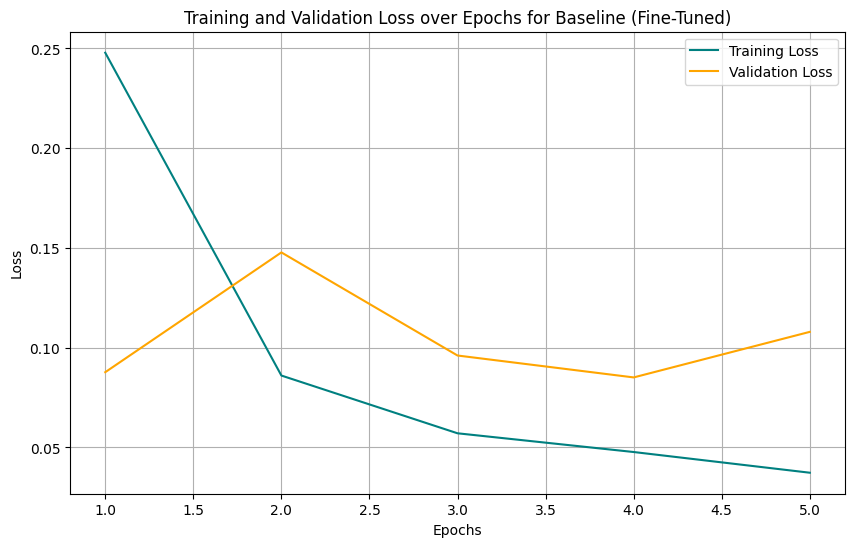

epoch,▁▃▅▆█
train_loss,█▃▂▁▁
val_loss,▁█▂▁▄
epoch,5
train_loss,0.03733
val_loss,0.10793


<Figure size 640x480 with 0 Axes>

In [15]:
# Graph training and validation losses from baseline_metrics
train_losses = baseline_metrics['train_losses']
val_losses = baseline_metrics['val_losses']
epochs = range(1, len(train_losses) + 1)

wandb.init(
    project="chemberta",
    entity="hpml-proj-deepchem",
    name="Baseline_Loss_Curves"
)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss', color='teal')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs for Baseline (Fine-Tuned)')
plt.legend()
plt.grid(True)
plt.show()

wandb.log({"baseline_train_val_loss": wandb.Image(plt)})

for i in range(len(train_losses)):
    wandb.log({
        "epoch": i+1,
        "train_loss": train_losses[i],
        "val_loss": val_losses[i]
    })

wandb.finish()

## ChemBeRTa With LoRA Fine-Tuning

In [16]:
def setup_lora_model(model_name):
    """
    Set up a model with LoRA configuration
    """
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,  # Binary classification for ClinTox
        return_dict=True
    )

    peft_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        inference_mode=False,
        r=LORA_R,
        lora_alpha=LORA_ALPHA,
        lora_dropout=LORA_DROPOUT,
        target_modules=["query", "value"]  # Target attention modules
    )

    model = get_peft_model(model, peft_config)
    return model


--- LoRA with learning_rate=1e-05 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.



--- LoRA_lr_1e-05 - Trainable Parameters ---
Trainable: 739586 | All: 44845060 | % Trained: 1.65



--- LoRA_lr_1e-05 ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.87it/s]


Epoch 1 | Training Time: 3.85 s | Train Loss: 0.4744 | Val Loss: 0.3164 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.91it/s]


Epoch 2 | Training Time: 3.85 s | Train Loss: 0.3088 | Val Loss: 0.2212 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 20.18it/s]


Epoch 3 | Training Time: 3.85 s | Train Loss: 0.2563 | Val Loss: 0.1899 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.96it/s]


Epoch 4 | Training Time: 3.87 s | Train Loss: 0.2315 | Val Loss: 0.1755 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.81it/s]


Epoch 5 | Training Time: 3.87 s | Train Loss: 0.2155 | Val Loss: 0.1652 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 20.02it/s]



--- LoRA_lr_1e-05 ---
Training time: 20.57 seconds
Test Loss: 0.1685 | Test Accuracy: 0.9392


epoch,▁▃▅▆█
epoch_time,▁▁▁▇█
parameter_efficiency,▁▁
test_accuracy,▁
test_loss,▁
total_parameters,▁▁
train_loss,█▄▂▁▁
trainable_parameters,▁▁
training_time,▁
val_accuracy,▁▁▁▁▁
val_loss,█▄▂▁▁



--- LoRA with learning_rate=2e-05 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- LoRA_lr_2e-05 - Trainable Parameters ---
Trainable: 739586 | All: 44845060 | % Trained: 1.65



--- LoRA_lr_2e-05 ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.74it/s]


Epoch 1 | Training Time: 3.87 s | Train Loss: 0.4462 | Val Loss: 0.2270 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.78it/s]


Epoch 2 | Training Time: 3.92 s | Train Loss: 0.2523 | Val Loss: 0.1789 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.76it/s]


Epoch 3 | Training Time: 3.92 s | Train Loss: 0.2148 | Val Loss: 0.1620 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.59it/s]


Epoch 4 | Training Time: 3.93 s | Train Loss: 0.1862 | Val Loss: 0.1465 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.53it/s]


Epoch 5 | Training Time: 3.96 s | Train Loss: 0.1625 | Val Loss: 0.1308 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.77it/s]



--- LoRA_lr_2e-05 ---
Training time: 20.89 seconds
Test Loss: 0.1229 | Test Accuracy: 0.9459


epoch,▁▃▅▆█
epoch_time,▁▅▅▆█
parameter_efficiency,▁▁
test_accuracy,▁
test_loss,▁
total_parameters,▁▁
train_loss,█▃▂▂▁
trainable_parameters,▁▁
training_time,▁
val_accuracy,▁▁▁▁▁
val_loss,█▄▃▂▁



--- LoRA with learning_rate=3e-05 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- LoRA_lr_3e-05 - Trainable Parameters ---
Trainable: 739586 | All: 44845060 | % Trained: 1.65



--- LoRA_lr_3e-05 ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.52it/s]


Epoch 1 | Training Time: 3.96 s | Train Loss: 0.3590 | Val Loss: 0.1828 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.50it/s]


Epoch 2 | Training Time: 3.99 s | Train Loss: 0.2208 | Val Loss: 0.1592 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.51it/s]


Epoch 3 | Training Time: 3.99 s | Train Loss: 0.1848 | Val Loss: 0.1397 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.56it/s]


Epoch 4 | Training Time: 3.99 s | Train Loss: 0.1447 | Val Loss: 0.1180 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.24it/s]


Epoch 5 | Training Time: 4.00 s | Train Loss: 0.1154 | Val Loss: 0.1026 | Val Accuracy: 0.9730


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.25it/s]



--- LoRA_lr_3e-05 ---
Training time: 21.25 seconds
Test Loss: 0.0890 | Test Accuracy: 0.9662


epoch,▁▃▅▆█
epoch_time,▁▅▆▆█
parameter_efficiency,▁▁
test_accuracy,▁
test_loss,▁
total_parameters,▁▁
train_loss,█▄▃▂▁
trainable_parameters,▁▁
training_time,▁
val_accuracy,▁▁▁▆█
val_loss,█▆▄▂▁



--- LoRA with learning_rate=5e-05 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- LoRA_lr_5e-05 - Trainable Parameters ---
Trainable: 739586 | All: 44845060 | % Trained: 1.65



--- LoRA_lr_5e-05 ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.58it/s]


Epoch 1 | Training Time: 3.96 s | Train Loss: 0.3202 | Val Loss: 0.1673 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.08it/s]


Epoch 2 | Training Time: 3.98 s | Train Loss: 0.1845 | Val Loss: 0.1337 | Val Accuracy: 0.9595


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 18.97it/s]


Epoch 3 | Training Time: 4.01 s | Train Loss: 0.1347 | Val Loss: 0.1064 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.35it/s]


Epoch 4 | Training Time: 4.00 s | Train Loss: 0.1006 | Val Loss: 0.0942 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.18it/s]


Epoch 5 | Training Time: 4.01 s | Train Loss: 0.0775 | Val Loss: 0.0957 | Val Accuracy: 0.9730


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.48it/s]



--- LoRA_lr_5e-05 ---
Training time: 21.29 seconds
Test Loss: 0.0770 | Test Accuracy: 0.9662


epoch,▁▃▅▆█
epoch_time,▁▄█▇█
parameter_efficiency,▁▁
test_accuracy,▁
test_loss,▁
total_parameters,▁▁
train_loss,█▄▃▂▁
trainable_parameters,▁▁
training_time,▁
val_accuracy,▁▃▅█▆
val_loss,█▅▂▁▁



--- LoRA with learning_rate=0.0001 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- LoRA_lr_0.0001 - Trainable Parameters ---
Trainable: 739586 | All: 44845060 | % Trained: 1.65



--- LoRA_lr_0.0001 ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.21it/s]


Epoch 1 | Training Time: 4.02 s | Train Loss: 0.2413 | Val Loss: 0.1343 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.01it/s]


Epoch 2 | Training Time: 4.04 s | Train Loss: 0.1273 | Val Loss: 0.0969 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 18.84it/s]


Epoch 3 | Training Time: 4.06 s | Train Loss: 0.0796 | Val Loss: 0.0929 | Val Accuracy: 0.9730


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.03it/s]


Epoch 4 | Training Time: 4.09 s | Train Loss: 0.0724 | Val Loss: 0.0906 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 18.95it/s]


Epoch 5 | Training Time: 4.08 s | Train Loss: 0.0569 | Val Loss: 0.0845 | Val Accuracy: 0.9730


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.39it/s]



--- LoRA_lr_0.0001 ---
Training time: 21.64 seconds
Test Loss: 0.0663 | Test Accuracy: 0.9730


epoch,▁▃▅▆█
epoch_time,▁▄▅█▇
parameter_efficiency,▁▁
test_accuracy,▁
test_loss,▁
total_parameters,▁▁
train_loss,█▄▂▂▁
trainable_parameters,▁▁
training_time,▁
val_accuracy,▁▅▆█▆
val_loss,█▃▂▂▁



--- LoRA with learning_rate=0.0003 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- LoRA_lr_0.0003 - Trainable Parameters ---
Trainable: 739586 | All: 44845060 | % Trained: 1.65



--- LoRA_lr_0.0003 ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.01it/s]


Epoch 1 | Training Time: 4.03 s | Train Loss: 0.1878 | Val Loss: 0.0951 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.08it/s]


Epoch 2 | Training Time: 4.04 s | Train Loss: 0.0833 | Val Loss: 0.0829 | Val Accuracy: 0.9730


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.06it/s]


Epoch 3 | Training Time: 4.05 s | Train Loss: 0.0677 | Val Loss: 0.1049 | Val Accuracy: 0.9595


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 18.97it/s]


Epoch 4 | Training Time: 4.07 s | Train Loss: 0.0522 | Val Loss: 0.0933 | Val Accuracy: 0.9392


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 18.84it/s]


Epoch 5 | Training Time: 4.07 s | Train Loss: 0.0399 | Val Loss: 0.0799 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.33it/s]



--- LoRA_lr_0.0003 ---
Training time: 21.6 seconds
Test Loss: 0.0608 | Test Accuracy: 0.9797


epoch,▁▃▅▆█
epoch_time,▁▂▄██
parameter_efficiency,▁▁
test_accuracy,▁
test_loss,▁
total_parameters,▁▁
train_loss,█▃▂▂▁
trainable_parameters,▁▁
training_time,▁
val_accuracy,█▇▅▁█
val_loss,▅▂█▅▁


,learning_rate,test_accuracy,training_time
0,0.00001,0.939189,20.57
1,0.00002,0.945946,20.89
2,0.00003,0.966216,21.25
3,0.00005,0.966216,21.29
4,0.00010,0.972973,21.64
5,0.00030,0.979730,21.60


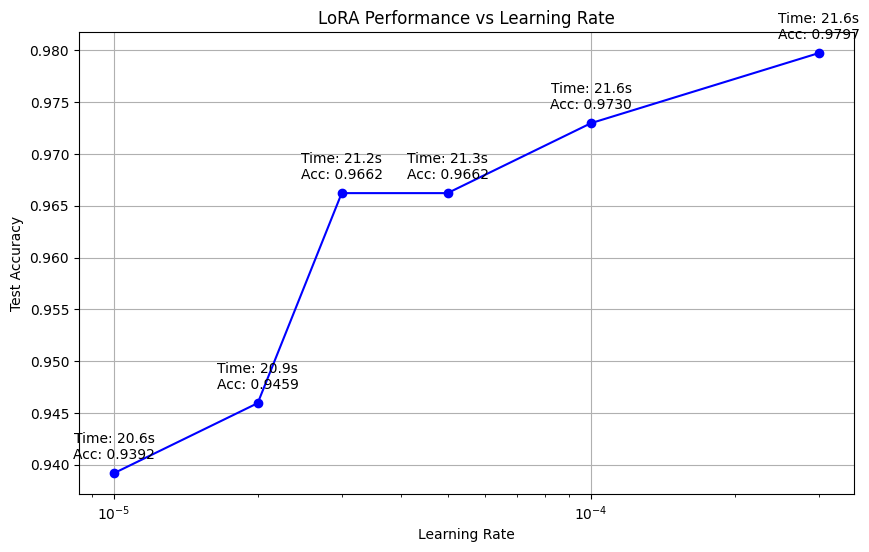

In [17]:
hyperparameter_tuning("LoRA")

In [18]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model_lora = setup_lora_model(MODEL_NAME)
BEST_LR_LORA = 3e-4
lora_metrics = train_and_profile(model_lora, tokenizer, "LoRA", lr=BEST_LR_LORA)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- LoRA - Trainable Parameters ---
Trainable: 739586 | All: 44845060 | % Trained: 1.65



--- LoRA ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.24it/s]


Epoch 1 | Training Time: 4.00 s | Train Loss: 0.1930 | Val Loss: 0.0989 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 18.78it/s]


Epoch 2 | Training Time: 4.02 s | Train Loss: 0.0702 | Val Loss: 0.0816 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 18.86it/s]


Epoch 3 | Training Time: 4.06 s | Train Loss: 0.0550 | Val Loss: 0.0827 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.20it/s]


Epoch 4 | Training Time: 4.06 s | Train Loss: 0.0491 | Val Loss: 0.1186 | Val Accuracy: 0.9324


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 18.78it/s]


Epoch 5 | Training Time: 4.06 s | Train Loss: 0.0421 | Val Loss: 0.1006 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.36it/s]



--- LoRA ---
Training time: 21.56 seconds
Test Loss: 0.0697 | Test Accuracy: 0.9797


epoch,▁▃▅▆█
epoch_time,▁▄█▇█
parameter_efficiency,▁▁
test_accuracy,▁
test_loss,▁
total_parameters,▁▁
train_loss,█▂▂▁▁
trainable_parameters,▁▁
training_time,▁
val_accuracy,▆██▁▆
val_loss,▄▁▁█▅


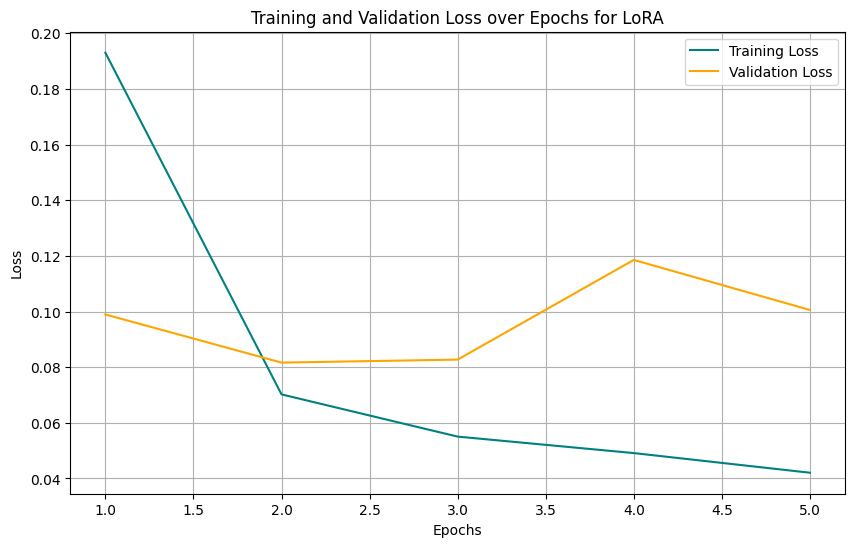

epoch,▁▃▅▆█
train_loss,█▂▂▁▁
val_loss,▄▁▁█▅
epoch,5
train_loss,0.04205
val_loss,0.10056


<Figure size 640x480 with 0 Axes>

In [19]:
# Graph training and validation losses from lora_metrics
train_losses = lora_metrics['train_losses']
val_losses = lora_metrics['val_losses']
epochs = range(1, len(train_losses) + 1)

wandb.init(
    project="chemberta",
    entity="hpml-proj-deepchem",
    name="LoRA_Loss_Curves"
)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss', color='teal')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs for LoRA')
plt.legend()
plt.grid(True)
plt.show()

wandb.log({"lora_train_val_loss": wandb.Image(plt)})

for i in range(len(train_losses)):
    wandb.log({
        "epoch": i+1,
        "train_loss": train_losses[i],
        "val_loss": val_losses[i]
    })

wandb.finish()

## ChemBeRTa With AdaLoRA Fine-Tuning

In [20]:
def setup_adalora_model(model_name):
    """
    Set up a model with AdaLoRA configuration
    """
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,  # Binary classification for ClinTox
        return_dict=True
    )

    train_dataset = ClinToxDataset("clintox", tokenizer, split="train", max_length=MAX_LENGTH)
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    ADA_TOTALSTEP = EPOCHS * len(train_dataloader)

    peft_config = AdaLoraConfig(
        task_type=TaskType.SEQ_CLS,
        inference_mode=False,
        r=LORA_R,
        lora_alpha=LORA_ALPHA,
        lora_dropout=LORA_DROPOUT,
        total_step = ADA_TOTALSTEP
    )

    model = get_peft_model(model, peft_config)
    return model


--- AdaLoRA with learning_rate=1e-05 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- AdaLoRA_lr_1e-05 - Trainable Parameters ---
Trainable: 1606335 | All: 45730290 | % Trained: 3.51



--- AdaLoRA_lr_1e-05 ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.09it/s]


Epoch 1 | Training Time: 6.02 s | Train Loss: 0.5863 | Val Loss: 0.3858 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.06it/s]


Epoch 2 | Training Time: 6.06 s | Train Loss: 0.3578 | Val Loss: 0.2494 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 14.85it/s]


Epoch 3 | Training Time: 6.10 s | Train Loss: 0.2800 | Val Loss: 0.2072 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 14.87it/s]


Epoch 4 | Training Time: 6.10 s | Train Loss: 0.2489 | Val Loss: 0.1868 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.05it/s]


Epoch 5 | Training Time: 6.08 s | Train Loss: 0.2305 | Val Loss: 0.1758 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.34it/s]



--- AdaLoRA_lr_1e-05 ---
Training time: 32.07 seconds
Test Loss: 0.1837 | Test Accuracy: 0.9324


epoch,▁▃▅▆█
epoch_time,▁▄██▆
parameter_efficiency,▁▁
test_accuracy,▁
test_loss,▁
total_parameters,▁▁
train_loss,█▄▂▁▁
trainable_parameters,▁▁
training_time,▁
val_accuracy,▁▁▁▁▁
val_loss,█▃▂▁▁



--- AdaLoRA with learning_rate=2e-05 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- AdaLoRA_lr_2e-05 - Trainable Parameters ---
Trainable: 1606335 | All: 45730290 | % Trained: 3.51



--- AdaLoRA_lr_2e-05 ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.30it/s]


Epoch 1 | Training Time: 6.03 s | Train Loss: 0.3684 | Val Loss: 0.2006 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.14it/s]


Epoch 2 | Training Time: 6.05 s | Train Loss: 0.2346 | Val Loss: 0.1702 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.04it/s]


Epoch 3 | Training Time: 6.08 s | Train Loss: 0.2095 | Val Loss: 0.1586 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.03it/s]


Epoch 4 | Training Time: 6.10 s | Train Loss: 0.1870 | Val Loss: 0.1498 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.02it/s]


Epoch 5 | Training Time: 6.09 s | Train Loss: 0.1731 | Val Loss: 0.1429 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.34it/s]



--- AdaLoRA_lr_2e-05 ---
Training time: 32.04 seconds
Test Loss: 0.1341 | Test Accuracy: 0.9459


epoch,▁▃▅▆█
epoch_time,▁▄▆█▇
parameter_efficiency,▁▁
test_accuracy,▁
test_loss,▁
total_parameters,▁▁
train_loss,█▃▂▁▁
trainable_parameters,▁▁
training_time,▁
val_accuracy,▁▁▁▁▁
val_loss,█▄▃▂▁



--- AdaLoRA with learning_rate=3e-05 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- AdaLoRA_lr_3e-05 - Trainable Parameters ---
Trainable: 1606335 | All: 45730290 | % Trained: 3.51



--- AdaLoRA_lr_3e-05 ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.15it/s]


Epoch 1 | Training Time: 6.02 s | Train Loss: 0.3615 | Val Loss: 0.1854 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.05it/s]


Epoch 2 | Training Time: 6.06 s | Train Loss: 0.2187 | Val Loss: 0.1632 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 14.95it/s]


Epoch 3 | Training Time: 6.09 s | Train Loss: 0.1913 | Val Loss: 0.1503 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 14.91it/s]


Epoch 4 | Training Time: 6.11 s | Train Loss: 0.1714 | Val Loss: 0.1408 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 14.96it/s]


Epoch 5 | Training Time: 6.10 s | Train Loss: 0.1573 | Val Loss: 0.1335 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.23it/s]



--- AdaLoRA_lr_3e-05 ---
Training time: 32.09 seconds
Test Loss: 0.1190 | Test Accuracy: 0.9459


epoch,▁▃▅▆█
epoch_time,▁▄▇█▇
parameter_efficiency,▁▁
test_accuracy,▁
test_loss,▁
total_parameters,▁▁
train_loss,█▃▂▁▁
trainable_parameters,▁▁
training_time,▁
val_accuracy,▁▁▁▁▁
val_loss,█▅▃▂▁



--- AdaLoRA with learning_rate=5e-05 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- AdaLoRA_lr_5e-05 - Trainable Parameters ---
Trainable: 1606335 | All: 45730290 | % Trained: 3.51



--- AdaLoRA_lr_5e-05 ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.05it/s]


Epoch 1 | Training Time: 6.03 s | Train Loss: 0.3235 | Val Loss: 0.1713 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 14.88it/s]


Epoch 2 | Training Time: 6.07 s | Train Loss: 0.1960 | Val Loss: 0.1507 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 14.91it/s]


Epoch 3 | Training Time: 6.10 s | Train Loss: 0.1657 | Val Loss: 0.1390 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.24it/s]


Epoch 4 | Training Time: 6.11 s | Train Loss: 0.1486 | Val Loss: 0.1289 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.13it/s]


Epoch 5 | Training Time: 6.08 s | Train Loss: 0.1340 | Val Loss: 0.1213 | Val Accuracy: 0.9595


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.17it/s]



--- AdaLoRA_lr_5e-05 ---
Training time: 32.1 seconds
Test Loss: 0.1126 | Test Accuracy: 0.9527


epoch,▁▃▅▆█
epoch_time,▁▅██▆
parameter_efficiency,▁▁
test_accuracy,▁
test_loss,▁
total_parameters,▁▁
train_loss,█▃▂▂▁
trainable_parameters,▁▁
training_time,▁
val_accuracy,▁▁▁▁█
val_loss,█▅▃▂▁



--- AdaLoRA with learning_rate=0.0001 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- AdaLoRA_lr_0.0001 - Trainable Parameters ---
Trainable: 1606335 | All: 45730290 | % Trained: 3.51



--- AdaLoRA_lr_0.0001 ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.31it/s]


Epoch 1 | Training Time: 6.00 s | Train Loss: 0.2724 | Val Loss: 0.1505 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.22it/s]


Epoch 2 | Training Time: 6.03 s | Train Loss: 0.1578 | Val Loss: 0.1303 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 14.95it/s]


Epoch 3 | Training Time: 6.07 s | Train Loss: 0.1295 | Val Loss: 0.1174 | Val Accuracy: 0.9595


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 14.92it/s]


Epoch 4 | Training Time: 6.11 s | Train Loss: 0.1137 | Val Loss: 0.1070 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.08it/s]


Epoch 5 | Training Time: 6.11 s | Train Loss: 0.0974 | Val Loss: 0.0946 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.09it/s]



--- AdaLoRA_lr_0.0001 ---
Training time: 32.02 seconds
Test Loss: 0.0800 | Test Accuracy: 0.9662


epoch,▁▃▅▆█
epoch_time,▁▃▅██
parameter_efficiency,▁▁
test_accuracy,▁
test_loss,▁
total_parameters,▁▁
train_loss,█▃▂▂▁
trainable_parameters,▁▁
training_time,▁
val_accuracy,▁▁▅██
val_loss,█▅▄▃▁



--- AdaLoRA with learning_rate=0.0003 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- AdaLoRA_lr_0.0003 - Trainable Parameters ---
Trainable: 1606335 | All: 45730290 | % Trained: 3.51



--- AdaLoRA_lr_0.0003 ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.22it/s]


Epoch 1 | Training Time: 6.04 s | Train Loss: 0.2257 | Val Loss: 0.1290 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.13it/s]


Epoch 2 | Training Time: 6.08 s | Train Loss: 0.1238 | Val Loss: 0.1061 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.00it/s]


Epoch 3 | Training Time: 6.11 s | Train Loss: 0.0818 | Val Loss: 0.0833 | Val Accuracy: 0.9730


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 14.88it/s]


Epoch 4 | Training Time: 6.12 s | Train Loss: 0.0621 | Val Loss: 0.0780 | Val Accuracy: 0.9865


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.11it/s]


Epoch 5 | Training Time: 6.10 s | Train Loss: 0.0494 | Val Loss: 0.1012 | Val Accuracy: 0.9459


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.18it/s]



--- AdaLoRA_lr_0.0003 ---
Training time: 32.15 seconds
Test Loss: 0.0675 | Test Accuracy: 0.9797


epoch,▁▃▅▆█
epoch_time,▁▅▇█▆
parameter_efficiency,▁▁
test_accuracy,▁
test_loss,▁
total_parameters,▁▁
train_loss,█▄▂▂▁
trainable_parameters,▁▁
training_time,▁
val_accuracy,▂▅▆█▁
val_loss,█▅▂▁▄


,learning_rate,test_accuracy,training_time
0,0.00001,0.932432,32.07
1,0.00002,0.945946,32.04
2,0.00003,0.945946,32.09
3,0.00005,0.952703,32.10
4,0.00010,0.966216,32.02
5,0.00030,0.979730,32.15


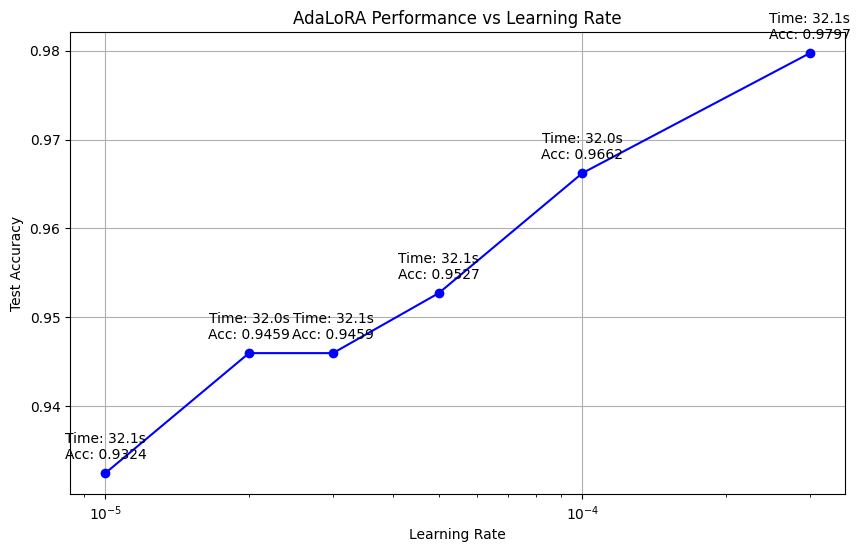

In [21]:
hyperparameter_tuning("AdaLoRA")

In [22]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model_adalora = setup_adalora_model(MODEL_NAME)
BEST_LR_ADALORA = 3e-4
adalora_metrics = train_and_profile(model_adalora, tokenizer, "AdaLoRA", lr = BEST_LR_LORA)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- AdaLoRA - Trainable Parameters ---
Trainable: 1606335 | All: 45730290 | % Trained: 3.51



--- AdaLoRA ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 14.96it/s]


Epoch 1 | Training Time: 6.01 s | Train Loss: 0.2263 | Val Loss: 0.1247 | Val Accuracy: 0.9595


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.11it/s]


Epoch 2 | Training Time: 6.04 s | Train Loss: 0.1245 | Val Loss: 0.1079 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.07it/s]


Epoch 3 | Training Time: 6.09 s | Train Loss: 0.0854 | Val Loss: 0.0814 | Val Accuracy: 0.9730


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 14.91it/s]


Epoch 4 | Training Time: 6.12 s | Train Loss: 0.0624 | Val Loss: 0.0775 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.06it/s]


Epoch 5 | Training Time: 6.13 s | Train Loss: 0.0542 | Val Loss: 0.1062 | Val Accuracy: 0.9595


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.10it/s]



--- AdaLoRA ---
Training time: 32.09 seconds
Test Loss: 0.0647 | Test Accuracy: 0.9797


epoch,▁▃▅▆█
epoch_time,▁▃▆▇█
parameter_efficiency,▁▁
test_accuracy,▁
test_loss,▁
total_parameters,▁▁
train_loss,█▄▂▁▁
trainable_parameters,▁▁
training_time,▁
val_accuracy,▁▃▆█▁
val_loss,█▆▂▁▅


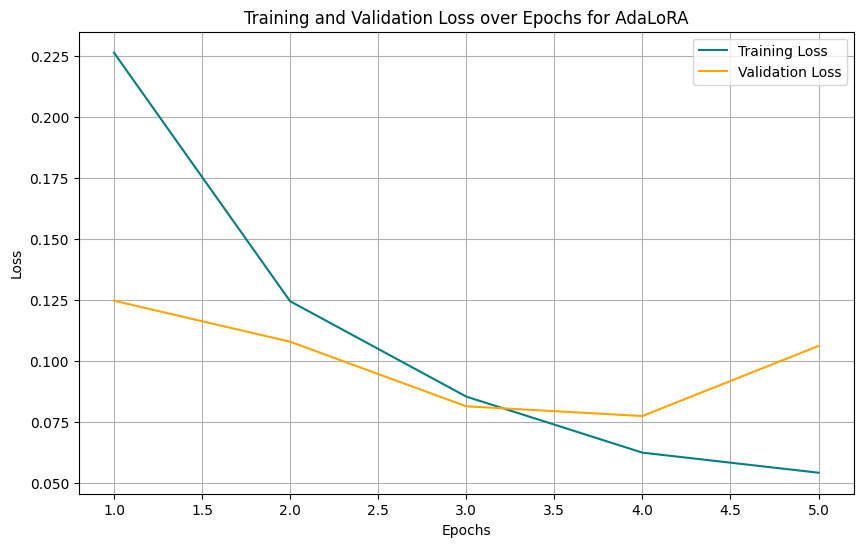

epoch,▁▃▅▆█
train_loss,█▄▂▁▁
val_loss,█▆▂▁▅
epoch,5
train_loss,0.05421
val_loss,0.10617


<Figure size 640x480 with 0 Axes>

In [23]:
# Graph training and validation losses from adalora_metrics
train_losses = adalora_metrics['train_losses']
val_losses = adalora_metrics['val_losses']
epochs = range(1, len(train_losses) + 1)

wandb.init(
    project="chemberta",
    entity="hpml-proj-deepchem",
    name="AdaLoRA_Loss_Curves"
)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss', color='teal')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs for AdaLoRA')
plt.legend()
plt.grid(True)
plt.show()

wandb.log({"adalora_train_val_loss": wandb.Image(plt)})

for i in range(len(train_losses)):
    wandb.log({
        "epoch": i+1,
        "train_loss": train_losses[i],
        "val_loss": val_losses[i]
    })

wandb.finish()

In [24]:
def compare_models(baseline_metrics, lora_metrics, adalora_metrics):
    """
    Log a bar chart comparing training time, test accuracy, and parameter count for all models.
    """
    wandb.init(project="chemberta", entity="hpml-proj-deepchem", name="Model_Comparison")
    models = ["Baseline", "LoRA", "AdaLoRA"]
    test_accuracies = [baseline_metrics["test_accuracy"], lora_metrics["test_accuracy"], adalora_metrics["test_accuracy"]]
    training_times = [baseline_metrics["training_time"], lora_metrics["training_time"], adalora_metrics["training_time"]]
    param_counts = [baseline_metrics["trainable_parameters"], lora_metrics["trainable_parameters"], adalora_metrics["trainable_parameters"]]

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    axs[0].bar(models, test_accuracies, color=["blue", "green", "red"])
    axs[0].set_title("Test Accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[1].bar(models, training_times, color=["blue", "green", "red"])
    axs[1].set_title("Training Time (s)")
    axs[1].set_ylabel("Seconds")
    axs[2].bar(models, param_counts, color=["blue", "green", "red"])
    axs[2].set_title("Trainable Parameters")
    axs[2].set_ylabel("Count")
    axs[2].set_yscale("log")
    plt.tight_layout()
    wandb.log({"model_comparison": wandb.Image(fig)})
    wandb.finish()


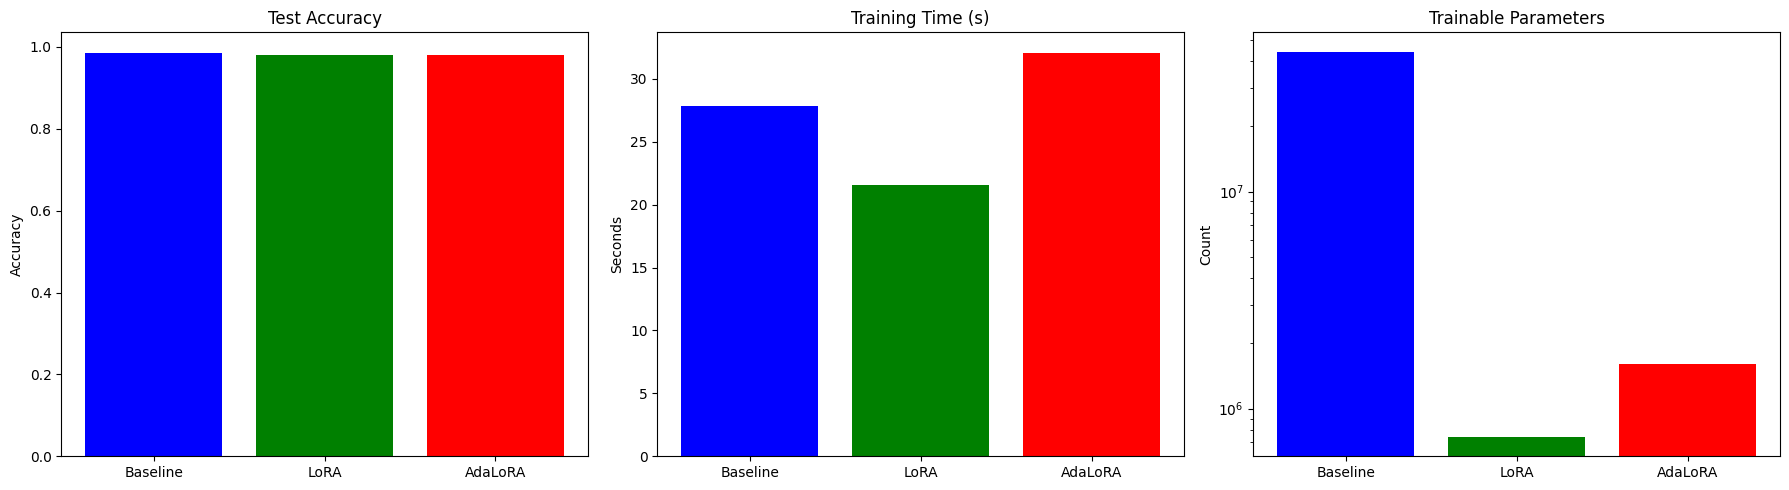

In [25]:
compare_models(baseline_metrics, lora_metrics, adalora_metrics)